# Integração de múltiplas amostras de Single cell RNA-Seq

## Instalar as bibliotecas necessárias

In [ ]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

Criaremos uma função R para realizar todos os comandos necessários para seguir o notebook

In [2]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

Instalar bibliotecas necessárias

In [ ]:
# Install the R.utils package
install.packages("R.utils")

# Install a specific commit/version of the Seurat Wrappers package from GitHub
remotes::install_github('satijalab/seurat-wrappers@d28512f804d5fe05e6d68900ca9221020d52cf1d', upgrade = FALSE)

# Install the Seurat Data package from GitHub
remotes::install_github('satijalab/seurat-data')

# Check if the BiocManager package is installed; if not, install it quietly
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", quiet = TRUE)

# Install the Harmony package for integrating single-cell datasets
install.packages("harmony")

## Introdução

Integração é uma técnica usada para combinar dados de células individuais de diferentes experimentos ou condições em um único espaço de análise. Isso é especialmente útil quando dados de diferentes lotes (batches) ou condições podem ser integrados para identificar padrões biológicos comuns. Neste exemplo de integração de múltiplos conjuntos de dados representando, por exemplo, diferentes condições biológicas, manuseio de amostras ou protocolos experimentais, exploraremos a integração realizada por [Seurat](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8) e [Harmony](https://www.nature.com/articles/s41592-019-0619-0)

In [ ]:
# Carregar bibliotecas
library(Seurat)
library(SeuratData)
library(SeuratWrappers)
library(cowplot)
library(harmony)
# Se o tempo de execução for maior que 2000 segundos, a execução irá parar
options(timeout=2000)

## Carregando dados

Aqui, carregamos os conjuntos de dados necessários para realizar uma análise de integração.

Este tutorial demonstra o processo de integração utilizando dados de células mononucleares do sangue periférico (peripheral blood mononuclear cells - PBMCs) [Kang et al, 2017](https://www.nature.com/articles/nbt.4042). O experimento são dois grupos distintos de PBMCs: um grupo controle e um grupo estimulado tratado com interferon beta. O tratamento induziu alterações na expressão gênica específicas nos tipos celulares, criando um desafio para a análise conjunta. Sem integração, as células podem se agrupar com base em sua condição de estimulação em vez de sua identidade intrínseca de tipo celular, complicando a interpretação dos resultados.

Para esclarecer, a integração visa alinhar os dados de ambos os grupos em um espaço comum, onde as células se agrupam por tipo, em vez de por condição de tratamento. Esse processo é essencial para identificar com precisão características compartilhadas e únicas entre os conjuntos de dados, minimizando a influência dos efeitos de lote introduzidos pelo delineamento experimental.

Etapas a seguir:
1. Carregar os conjuntos de dados de PBMCs: Utilize dados de expressão gênica pré-processados ​​do estudo de Kang.
2. Inspecionar a composição do conjunto de dados: Verifique se os grupos controle e estimulado estão incluídos e verifique se há representação adequada do tipo de célula.
3. Realizar a integração: Utilize ferramentas de integração como Seurat ou Harmony para combinar os conjuntos de dados, considerando os efeitos de lote.
4. Visualizar os resultados: Examine o agrupamento para garantir que as células sejam agrupadas principalmente por tipo, e não por condição de tratamento.

In [ ]:
# Instalar o dataset
InstallData("ifnb")

In [ ]:
# Carregar o dataset
LoadData("ifnb")

In [ ]:
# Transferir os dados de ifnb para o dado sc_dataset
sc_datasets <- ifnb

In [ ]:
# %>%: Este é o operador do pacote dplyr. Ele permite encadear operações de forma legível, passando o resultado de uma operação como entrada para a próxima.
# glimpse é uma função do pacote dplyr que fornece uma visualização rápida e concisa do conjunto de dados, mostrando os primeiros valores de cada coluna e as respectivas classes.

sc_datasets %>% dplyr::glimpse()

## Processamento dos dados

Nós pré-processamos os dados até um ponto que é comum para a integração de dados do Seurat e do Harmony

In [ ]:
# Atualiza o objeto Seurat para o formato mais recente, corrigindo problemas de compatibilidade com objetos Seurat mais antigos
sc_datasets <- UpdateSeuratObject(object = sc_datasets)
# Se esta etapa for ignorada, ocorrerá o erro: 'nenhum slot de nome "images" para este objeto da classe "Seurat"

# Normaliza os dados de expressão genética no objeto Seurat
sc_datasets <- Seurat::NormalizeData(sc_datasets, verbose = FALSE)

A função NormalizeData do Seurat simplifica os dados brutos de scRNA-seq em um formato padronizado, facilitando a comparação de células e a detecção de padrões biológicos significativos. Esse processo envolve três etapas principais:

1. Escalonamente de Contagens: Para cada gene, a contagem em uma determinada célula é dividida pelo número total de contagens de todos os genes naquela célula. Isso ajusta as diferenças na profundidade do sequenciamento entre as células, garantindo comparações justas.

2. Ajuste de Escalonamento: O resultado da primeira etapa é multiplicado por um fator de escala (comumente definido como 10.000). Isso torna os valores normalizados mais interpretáveis, assemelhando-se aproximadamente a contagens por 10.000 leituras.

3. Transformação Logarítmica: Por fim, as contagens escalonadas são transformadas usando uma função logarítmica. Essa etapa reduz o efeito de valores extremamente altos ou baixos, facilitando a detecção de padrões nos dados.

Este método é essencial porque garante que quaisquer diferenças observadas entre as células reflitam variações biológicas verdadeiras, e não diferenças técnicas do processo de sequenciamento.

In [ ]:
# Visualize a estrutura do objeto Seurat, incluindo metadados e dados de recursos
dplyr::glimpse(sc_datasets)

## Execute a integração de dados do Seurat

A integração aqui realizada com Seurat consiste na utilização de uma Análise de Correlação Canônica para identificar âncoras entre conjuntos de dados, conforme indicado no [artigo original](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8):

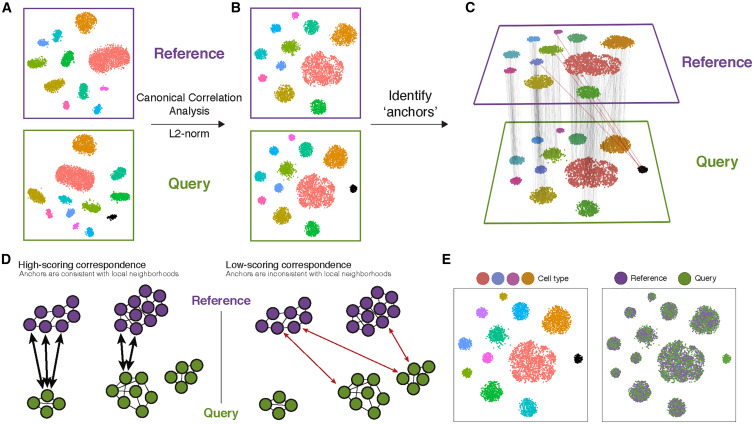

Dividir conjunto de dados em uma lista de conjuntos de dados

In [ ]:
# Dividir (split) o objeto Seurat em uma lista de objetos Seurat menores com base na coluna de metadados "stim"
sc_datasets.list <- SplitObject(sc_datasets, split.by = "stim")

Encontre características altamente variáveis ​​para cada condição separadamente

In [ ]:
# Identifique os 2.000 principais recursos variáveis ​​para cada conjunto de dados na lista
sc_datasets.list <- lapply(X = sc_datasets.list, FUN = function(x) {
                    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000) })

Encontre os recursos que são repetidamente variáveis ​​em conjuntos de dados para integração (anchor features).

In [ ]:
# Identificar recursos de integração a serem usados ​​para alinhar conjuntos de dados
features <- SelectIntegrationFeatures(object.list = sc_datasets.list)

Encontre as âncoras de integração ou o conjunto final de genes altamente variáveis ​​mais frequentemente selecionados nos lotes (batches)

In [ ]:
# Encontre âncoras de integração entre os conjuntos de dados usando os recursos selecionados

sc_datasets.anchors <- FindIntegrationAnchors(object.list = sc_datasets.list, anchor.features = features)

# Abaixo está o resumo do processo em execução que aparecerá na sua tela

Integrar conjuntos de dados - Cria um ensaio de dados integrado

In [ ]:
# Integre os conjuntos de dados em um único objeto Seurat usando as âncoras de integração
sc_datasets.combined <- IntegrateData(anchorset = sc_datasets.anchors)

# Abaixo está o resumo do processo em execução que aparecerá na sua tela

In [ ]:
# Veja a estrutura do objeto Seurat integrado
dplyr::glimpse(sc_datasets.combined)

Execute o fluxo de trabalho padrão para visualização e agrupamento.

In [ ]:
# Escalone os dados integrados, execute PCA, execute UMAP para redução de dimensionalidade, encontre vizinhos e agrupe células
sc_datasets.combined <- ScaleData(sc_datasets.combined, verbose = FALSE) %>%
                        RunPCA(npcs = 30, verbose = FALSE) %>%
                        RunUMAP(reduction = "pca", dims = 1:30) %>%
                        FindNeighbors(reduction = "pca", dims = 1:30) %>%
                        FindClusters(resolution = 0.5)

In [ ]:

# Defina o tamanho dos gráficos para visualização
options(repr.plot.height = 5, repr.plot.width = 16)

# Visualização: Crie gráficos UMAP com diferentes opções de agrupamento ou rotulagem
p1 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")  # Agrupe células por metadados "stim"
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE) # Rotule clusters no UMAP
p3 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "seurat_annotations")  # Agrupe por anotações

p1 + p2 + p3 # Combine os gráficos

## Execute Harmony

Do [artigo original](https://www.nature.com/articles/s41592-019-0619-0) do Harmony: "O PCA incorpora células em um espaço com dimensionalidade reduzida. O Harmony aceita as coordenadas da célula neste espaço reduzido e executa um algoritmo iterativo para ajustar os efeitos específicos do conjunto de dados.

**a.** O Harmony usa agrupamentos difusos para atribuir cada célula a múltiplos agrupamentos, enquanto um termo de penalidade garante que a diversidade dos conjuntos de dados dentro de cada agrupamento seja maximizada.

**b.** O Harmony calcula uma centralidade global para cada agrupamento, bem como centralidades específicos do conjunto de dados para cada agrupamento.

**c.** Dentro de cada agrupamento, o Harmony calcula um fator de correção para cada conjunto de dados com base nas centralidades.

**d.** Por fim, o Harmony corrige cada célula com um fator específico da célula: uma combinação linear de fatores de correção do conjunto de dados ponderados pelas atribuições suaves de agrupamento da célula feitas na etapa a. O Harmony repete as etapas de a a d até a convergência. A dependência entre a atribuição de clusters e o conjunto de dados diminui a cada rodada. Os conjuntos de dados são representados com cores e os tipos de células com formatos diferentes."

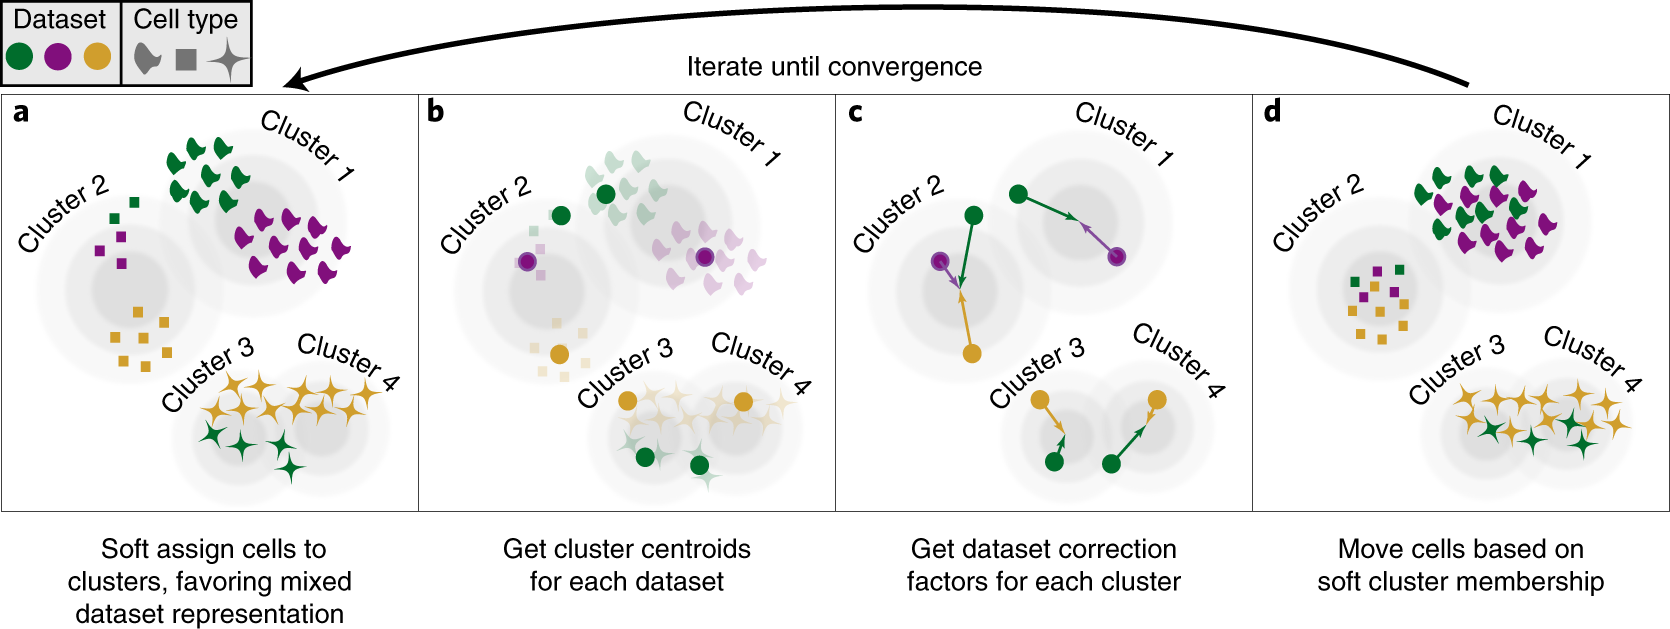



In [ ]:
# Defina o tamanho dos gráficos para visualização
options(repr.plot.height = 4, repr.plot.width = 6)

# Encontre recursos variáveis (Variable Features), escalone dados, execute PCA e integre usando Harmony
sc_datasets.harmony <- FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                       ScaleData(verbose = FALSE) %>%
                       RunPCA(npcs = 30, verbose = FALSE) %>%
                       RunHarmony("stim", plot_convergence = TRUE)  # Integrar usando "stim" como uma variável de lote

Para acessar diretamente os embeddings harmonizados:


In [ ]:
# Extraia embeddings Harmony (representações de baixa dimensão) e exiba as primeiras 5 linhas e colunas
harmony_embeddings <- Embeddings(sc_datasets.harmony, 'harmony')
harmony_embeddings[1:5, 1:5]

Conclua o fluxo de trabalho padrão para visualização e agrupamento

In [ ]:
# Execute UMAP usando embeddings Harmony, encontre vizinhos e agrupe células
sc_datasets.harmony <- RunUMAP(sc_datasets.harmony, reduction = "harmony", dims = 1:30) %>%
                       FindNeighbors(reduction = "harmony", dims = 1:30) %>%
                       FindClusters(resolution = 0.5)

In [ ]:
#  Defina o tamanho dos gráficos para visualização
options(repr.plot.height = 5, repr.plot.width = 16)

# Visualização: Crie gráficos UMAP com diferentes opções de agrupamento ou rotulagem
p1 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")  # Agrupar por "stim"
p2 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)  # Rotular de agrupamentos (clusters)
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "seurat_annotations")  # Agrupar por anotação
p1 + p2 + p3  # Combine os gráficos

## Métricas de Integração

Inspecionar a mistura dentro do cluster

Usaremos uma função para criar um gráfico da composição do lote de cada cluster.

Esta função foi retirada de:https://github.com/cellgeni/scRNA.seq.course/blob/master/course_files/utils/custom_seurat_functions.R

In [ ]:
# Defina uma função personalizada para visualizar a distribuição de clusters em conjuntos de dados
plot_integrated_clusters = function(srat, batchcolumn) {
# Pegue um objeto Seurat integrado e plote as distribuições na "batchcolumn"
  library(Seurat)
  library(patchwork)
  library(ggplot2)
  library(reshape2)
  library(RColorBrewer)

  # Cria uma tabela de contagens de células por cluster e conjunto de dados
  count_table <- table(srat@meta.data$seurat_clusters, srat@meta.data[[batchcolumn]])
  count_mtx   <- as.data.frame.matrix(count_table)  # Converte a tabela em um dataframe
  count_mtx$cluster <- rownames(count_mtx)  # Adiciona identificadores de cluster como uma coluna
  melt_mtx    <- melt(count_mtx)  # Remodela os dados para ggplot
  melt_mtx$cluster <- as.factor(melt_mtx$cluster)  # Converte a coluna do cluster em um fator

  # Calcule o tamanho dos agrupamentos (clusters)
  cluster_size   <- aggregate(value ~ cluster, data = melt_mtx, FUN = sum)

  # Organize os agrupamentos por tamanho
  sorted_labels <- paste(sort(as.integer(levels(cluster_size$cluster)), decreasing = TRUE))
  cluster_size$cluster <- factor(cluster_size$cluster, levels = sorted_labels)
  melt_mtx$cluster <- factor(melt_mtx$cluster, levels = sorted_labels)

  colnames(melt_mtx)[2] <- "dataset" # Renomear coluna para maior clareza

 # Trace a distribuição de células por cluster (escala logarítmica)
  p1 <- ggplot(cluster_size, aes(y = cluster, x = value)) +
        geom_bar(position = "dodge", stat = "identity", fill = "grey60") +
        theme_bw() + scale_x_log10() + xlab("Cells per cluster, log10 scale") + ylab("")

  # Trace uma fração de células em cada conjunto de dados para cada agrupamento
  p2 <- ggplot(melt_mtx, aes(x = cluster, y = value, fill = dataset)) +
        geom_bar(position = "fill", stat = "identity") +
        theme_bw() + coord_flip() +
        scale_fill_brewer(palette = "Set2") +
        ylab("Fraction of cells in each dataset") + xlab("Cluster number") + theme(legend.position = "top")

  p2 + p1 + plot_layout(widths = c(3, 1))  # Combine os gráficos
}

In [ ]:
# Visualizar agrupamentos para conjuntos de dados integrados
plot_integrated_clusters(sc_datasets.combined, 'stim')

In [ ]:
# Visualizar agrupamentos pelo Harmony
plot_integrated_clusters(sc_datasets.harmony, 'stim')

Isso mede o quão bem misturado é um conjunto de dados composto. De acordo com[este link](https://github.com/satijalab/Integration2019/issues/1#issuecomment-573757488), pontuações mais baixas representam uma melhor mistura. Veja também [este código](https://github.com/satijalab/Integration2019/blob/e5821bd242fa0a46eb6fd37764275737512032a4/analysis_code/integration/integration_metrics.R#L43C1-L45C124)

Esta métrica avalia se a vizinhança de uma célula está bem misturada. Em outras palavras, se ela contém um pequeno número de células de cada conjunto de dados (por exemplo, k = 5).

In [ ]:
# Calcular a métrica de mistura para dados integrados de Seurat
seurat_mixing <- MixingMetric(sc_datasets.combined,
                              'seurat_clusters', # Coluna para avaliar a mistura
                              reduction = "pca", # Usar embeddings de PCA
                              dims = 1:2,        # Avaliar as duas primeiras dimensões
                              k = 5,             # Número de vizinhos mais próximos
                              max.k = 300,       # Número máximo de vizinhos
                              eps = 0,           # Tolerância para busca de vizinhos
                              verbose = TRUE     # Exibir progresso
                             )

In [ ]:
# Calcular a média da métrica de mistura de Seurat
mean(seurat_mixing)

In [ ]:
# Calcular o desvio padrão da métrica de mistura de Seurat
sd(seurat_mixing)

In [ ]:
# Calcular a métrica de mistura para dados integrados do Harmony
harmony_mixing <- MixingMetric(sc_datasets.harmony,
                               'seurat_clusters',
                               reduction = "harmony",
                               dims = 1:2,
                               k = 5,
                               max.k = 300,
                               eps = 0,
                               verbose = TRUE
                             )

In [ ]:
# Calcular a média da métrica de mistura Harmony
mean(harmony_mixing)

In [ ]:
# Calcular o desvio padrão da métrica de mistura Harmony
sd(harmony_mixing)

# Vamos comparar quando usamos nenhuma integração, Seurat e Harmony:

In [ ]:
# Identifique as 2.000 características mais variáveis ​​(genes) usando o método "vst".
# Essas características são usadas para análise a jusante (downstream analysis)
sc_datasets <- FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                
# Escalone e centralize os dados para as características variáveis ​​identificadas.
# Isso padroniza os valores da expressão entre as células.
                ScaleData(verbose = FALSE) %>%
                
# Performe Principal Component Analysis (PCA) para reduzir a dimensionalidade.
# Retenha os primeiros 30 componentes principais para análise a jusante (downstream analysis).
                RunPCA(npcs = 30, verbose = FALSE) %>%

## Aplique a Aproximação e Projeção Uniforme de Variedades (UMAP) para redução da dimensionalidade não linear.
# Use os resultados do PCA como arquivo de entrada (input) e os primeiros 30 componentes principais.
                RunUMAP(reduction = "pca", dims = 1:30) %>%
                
# Calcula um grafo de vizinho mais próximo compartilhado (shared nearest neighbor - SNN) para agrupamento.
# Esta etapa identifica relacionamentos entre células com base em seus embeddings UMAP.
                FindNeighbors(reduction = "pca", dims = 1:30) %>%
                
# Executa o agrupamento de células usando o grafo SNN.
# A resolução controla a granularidade dos clusters (maior resolução = mais clusters).
                FindClusters(resolution = 0.5)

In [ ]:
# Defina o tamanho da visualização de saída.
options(repr.plot.height = 5, repr.plot.width = 16)

# Crie um gráfico UMAP agrupando as células pela coluna de metadados "stim".
p1 <- DimPlot(sc_datasets, reduction = "umap", group.by = "stim")

# Crie um gráfico UMAP para o conjunto de dados integrado, agrupando as células pela coluna de metadados "stim".
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")

# Crie um gráfico UMAP para o conjunto de dados corrigido por Harmonia, agrupando as células pela coluna de metadados "stim".
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")

# Combine os três gráficos UMAP em uma única visualização.
p1 + p2 + p3

In [ ]:
# Defina a altura e a largura da visualização de saída.
options(repr.plot.height = 5, repr.plot.width = 16)

# Crie um gráfico UMAP para o objeto sc_datasets original.
# O parâmetro 'label' adiciona rótulos aos clusters no gráfico.
# O parâmetro 'repel' impede a sobreposição de rótulos de texto.
p1 <- DimPlot(sc_datasets, reduction = "umap", label = TRUE, repel = TRUE)

# Crie um gráfico UMAP para o objeto sc_datasets combinado.
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)

# Crie um gráfico UMAP para o objeto sc_datasets com a harmonia corrigida.
# Este gráfico também usa UMAP, com rótulos e repeling para evitar sobreposições.
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)

p1 + p2 + p3 #Combine os gráficos

## Perguntas

- Qual a diferença entre os resultados da integração de Seurat e Harmony?

- Por que isso pode acontecer?

- Você consegue identificar quais marcadores mudaram nos clusters gerados por um método em comparação ao outro?

?DimPlot

# Benchmarking 

Realizamos a integração de dados de célula única utilizando diferentes ferramentas, o que nos permitiu observar variações nos agrupamentos celulares gerados por cada abordagem. Essas diferenças levantam um ponto crucial: como decidir qual método de integração é mais adequado para cada contexto de análise?

Essa pergunta nos leva à necessidade de uma avaliação sistemática — ou benchmark — dos métodos de integração. Para isso, é essencial considerar critérios objetivos, como a precisão na segmentação celular e a capacidade de cada método em corrigir efeitos de lote, sem comprometer a estrutura biológica dos dados.

Ao adotar essa perspectiva comparativa, podemos avançar na escolha fundamentada da ferramenta de integração mais apropriada, considerando os objetivos específicos de cada estudo — seja em análises exploratórias ou em aplicações clínicas.

Para responder de forma sistemática à pergunta sobre qual método de integração adotar, utilizamos a ferramenta (`scib-metrics`)[https://scib-metrics.readthedocs.io/en/stable/], desenvolvida especificamente para o benchmark de métodos aplicados à análise de dados de transcriptoma de célula única.

O scib-metrics oferece um conjunto padronizado de métricas quantitativas que permitem avaliar diferentes aspectos dos resultados de integração, como:

* Correção de batch effect

* Preservação da estrutura biológica

* Separação e coesão dos agrupamentos celulares

Essa ferramenta pode ser usada em linguagem Python ou em ambiente virtual como Miniconda ou ainda em Docker. Abaixo um exemplo de como podemos usa-lá

### NOTA: não iremos executar neste notebook
O notebook foi configurado para análises em R, abaixo segue como executar em Python e os resultados possíveis

In [ ]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection #instalar os pacotes necessários do scib_metrics

# Inicializa o objeto Benchmarker para comparar os diferentes embeddings produzidos pelas ferramentas de integração
bm = Benchmarker(
    adata,  # Objeto de dados carregado em memória (AnnData), contendo as expressões, metadados e edados de PCA/UMAP/mbeddings.
    batch_key="batch",  # Anotação de lote experimental, usada para avaliar correção de batch effect.
    label_key="cell_type",  # Anotação com os rótulos dos tipos celulares, usada para medir a preservação biológica dos agrupamentos.
    embedding_obsm_keys=[  # Lista dos nomes dos embeddings no adata.obsm gerados por diferentes métodos de integração
        "Unintegrated",     # Embedding sem integração (referência)
        "Seurat",           # Embedding integrado com Seurat
        "Harmony"           # Embedding integrado com Harmony
    # Podemos utilizar outras ferramentas de integração também como:
       # "scVI",            # Embedding com scVI (modelo probabilístico)
       # "scANVI"           # Embedding com scANVI (modelo supervisionado)
    ],
    n_jobs=2  # Número de núcleos para paralelizar o cálculo das métricas (threads que estamos disponibilizando para executara)
)

# Executa o benchmark para avaliar e comparar os embeddings especificados,
# considerando correção de batch e preservação de identidade celular
bm.benchmark()


Temos um resultado semelhante a esse: 
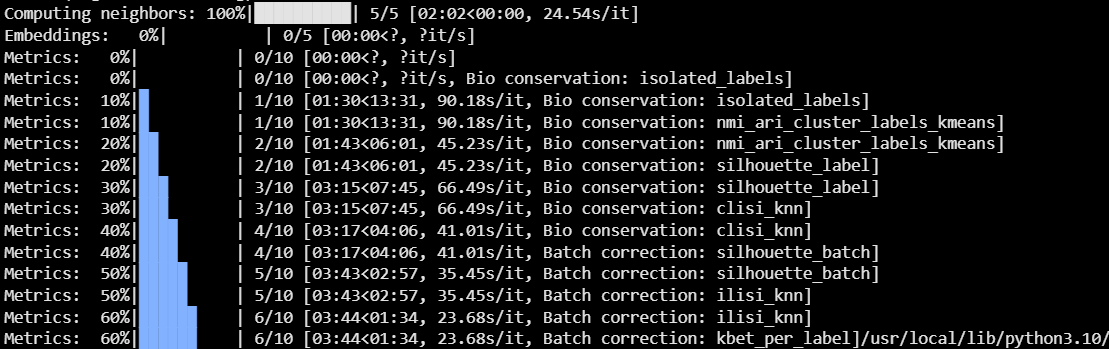
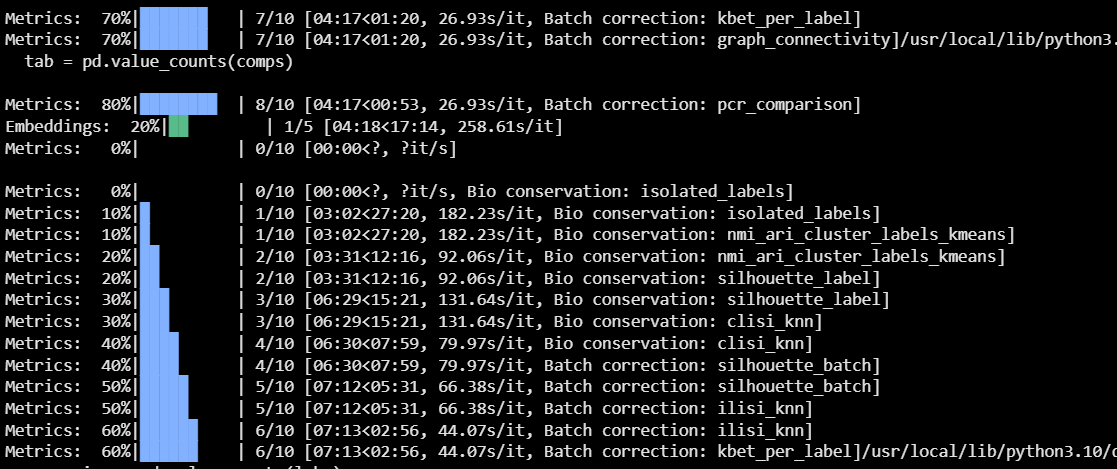
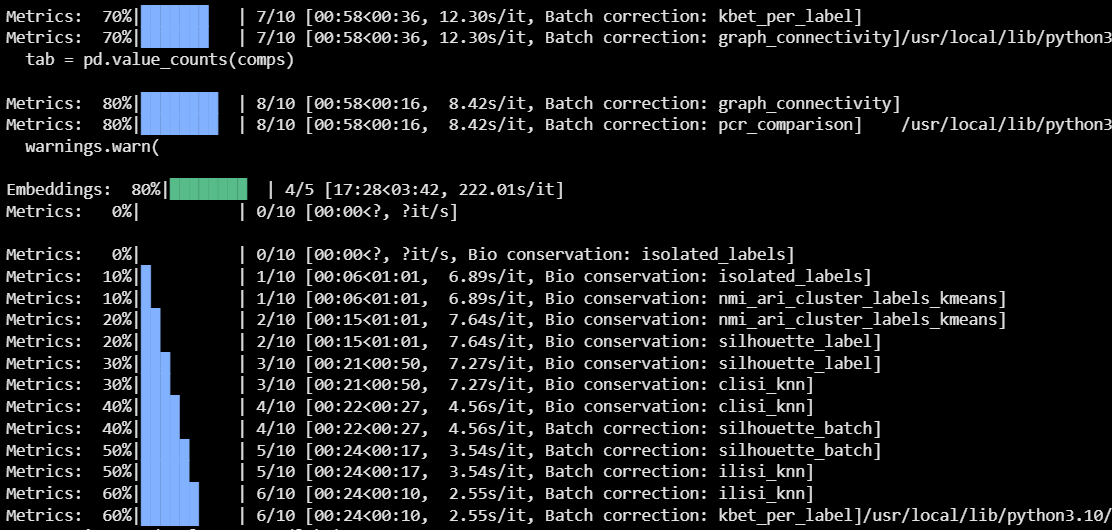
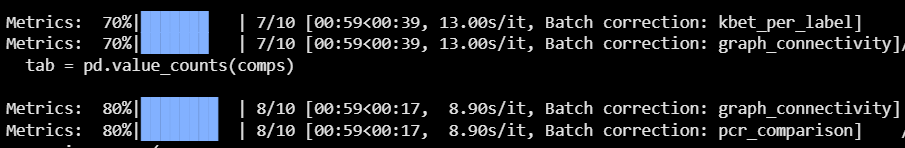

Apesar de tudo, não é tão simples de entender qual escolher, então fizemos 

In [ ]:
bm.plot_results_table()

Resultado se parece assim:

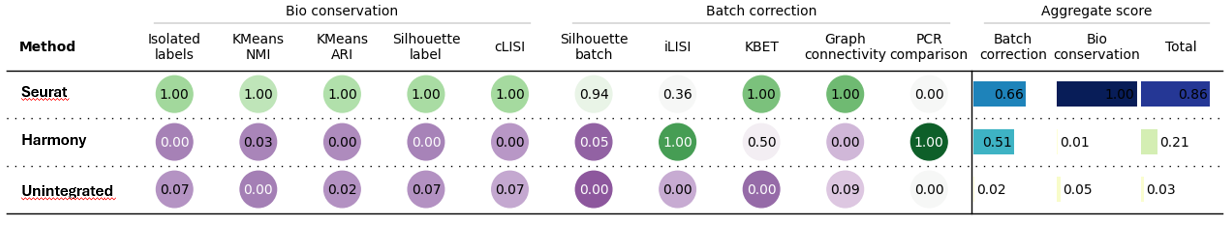

In [ ]:
#Também pode solicitar para que mostre a saída como tabela:

from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

#E depois fazer a transposição dos dados, para inverter a posição de linhas e colunas:

df.transpose()